# Pre-processing

In [ ]:
import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pickle
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/Dataset"
!unzip "/content/gdrive/My Drive/Dataset/Dataset.zip";

data.pickle  real_and_fake_face		   vgg.png
Dataset.zip  real_and_fake_face_detection
Archive:  /content/gdrive/My Drive/Dataset/Dataset.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  

We store the dataset in a dataframe using the image directories instead of the images themselves

In [ ]:
training_fake_dir = glob.glob("/content/real_and_fake_face/training_fake/*")
training_real_dir = glob.glob("/content/real_and_fake_face/training_real/*")

In [ ]:
dataset = pd.DataFrame()

We represent the 'fake' class with '0' and the 'real' class with '1'

In [ ]:
dataset['Image_ID'] = training_fake_dir
dataset['Label'] = "0"
dataset = dataset.append(pd.DataFrame({'Image_ID':training_real_dir, 'Label':"1"}), ignore_index=True)

In [ ]:
dataset

,Image_ID,Label
0,/content/real_and_fake_face/training_fake/mid_...,0
1,/content/real_and_fake_face/training_fake/hard...,0
2,/content/real_and_fake_face/training_fake/mid_...,0
3,/content/real_and_fake_face/training_fake/mid_...,0
4,/content/real_and_fake_face/training_fake/mid_...,0
...,...,...
2036,/content/real_and_fake_face/training_real/real...,1
2037,/content/real_and_fake_face/training_real/real...,1
2038,/content/real_and_fake_face/training_real/real...,1
2039,/content/real_and_fake_face/training_real/real...,1


Sample Fake Image

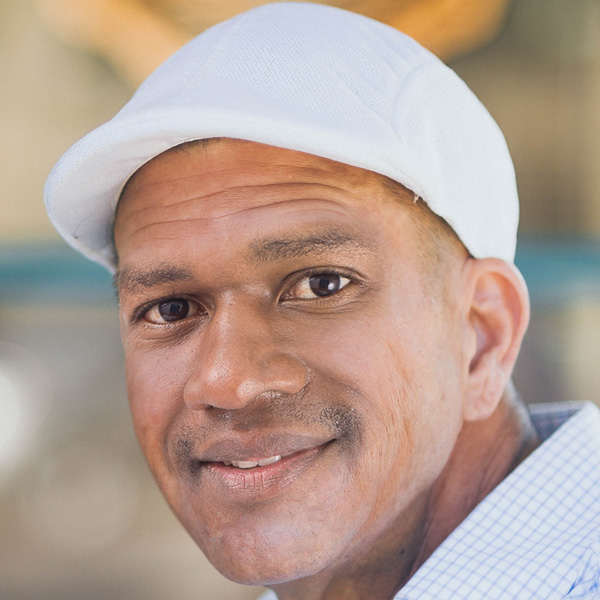

In [ ]:
Image.open(dataset.iloc[0]['Image_ID'])

Sample Real Image

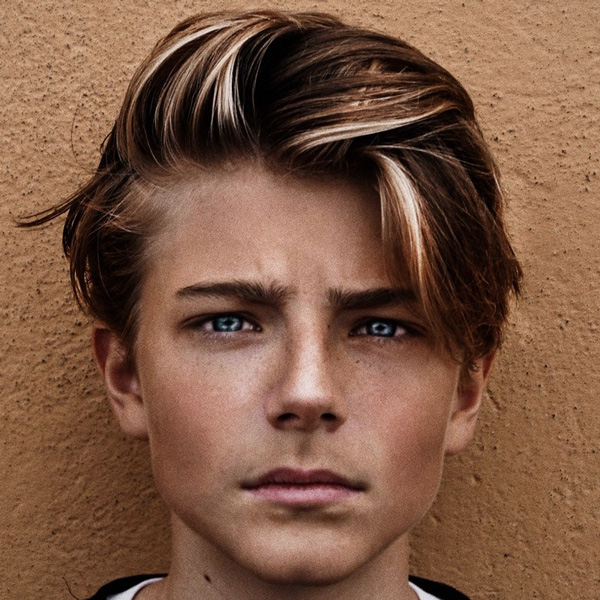

In [ ]:
Image.open(dataset.iloc[-1]['Image_ID'])

Shuffle the Dataset

In [ ]:
dataset = dataset.sample(frac=1)

In [ ]:
dataset

,Image_ID,Label
70,/content/real_and_fake_face/training_fake/easy...,0
326,/content/real_and_fake_face/training_fake/mid_...,0
418,/content/real_and_fake_face/training_fake/mid_...,0
356,/content/real_and_fake_face/training_fake/easy...,0
1924,/content/real_and_fake_face/training_real/real...,1
...,...,...
248,/content/real_and_fake_face/training_fake/mid_...,0
882,/content/real_and_fake_face/training_fake/easy...,0
757,/content/real_and_fake_face/training_fake/easy...,0
772,/content/real_and_fake_face/training_fake/mid_...,0


In [ ]:
import cv2

In [ ]:
data[0][0].shape

(600, 600, 3)

In [ ]:
data[0]

[array([[[206, 213, 221],
         [204, 211, 219],
         [205, 212, 220],
         ...,
         [203, 210, 216],
         [206, 213, 219],
         [198, 205, 211]],
 
        [[204, 211, 219],
         [203, 210, 218],
         [205, 212, 220],
         ...,
         [201, 208, 214],
         [203, 210, 216],
         [199, 206, 212]],
 
        [[208, 215, 223],
         [205, 212, 220],
         [206, 213, 221],
         ...,
         [199, 206, 214],
         [200, 207, 215],
         [202, 209, 217]],
 
        ...,
 
        [[ 13,  12,  18],
         [ 15,  14,  20],
         [ 21,  20,  25],
         ...,
         [141, 148, 156],
         [140, 147, 155],
         [139, 146, 154]],
 
        [[ 18,  17,  23],
         [ 17,  16,  22],
         [ 18,  17,  23],
         ...,
         [141, 148, 156],
         [141, 148, 156],
         [144, 151, 159]],
 
        [[ 15,  16,  21],
         [ 16,  17,  22],
         [ 14,  15,  20],
         ...,
         [140, 147, 155],
  

In [ ]:
dataset = dataset.sample(frac=1)

In [ ]:
n=64

In [ ]:
x_data = np.asarray([img_to_array(load_img(i, target_size=(n, n))) for i in dataset['Image_ID']])
y_data = np.asarray([np.asarray(i) for i in dataset['Label']])
y_data = y_data.astype(np.float32)

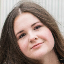

In [ ]:
Image.fromarray(x_data[0].astype(np.uint8))

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(brightness_range=[0.6,0.8], 
                             horizontal_flip=True, 
                             # vertical_flip=True,
                             rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             # validation_split=0.2
                             )

train_gen = datagen.flow(x_data, y_data, batch_size=len(x_data))
# validation_gen = datagen.flow(x_data, y_data, 32, subset = 'validation')

In [ ]:
x, y = train_gen.next()
y = y.reshape(2041, 1) 
for i in range(10):
  temp_x, temp_y = train_gen.next()
  temp_y = temp_y.reshape(2041, 1)
  x = np.vstack((x, temp_x))
  y = np.vstack((y, temp_y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#Random Forest

In [ ]:
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
Applying PCA to the data

In [ ]:
faces_pca = PCA(n_components=0.8)

Training PCA

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
N, H, W, C = x_train.shape
x_train = np.resize(x_train, (N, H*W*C))
N_test, H, W, C = x_test.shape
x_test = np.resize(x_test, (N_test, H*C*W))

In [ ]:
faces_pca.fit(x_train)


PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
x1_train = faces_pca.transform(x_train)
x1_test = faces_pca.transform(x_test)

In [ ]:
rf = RandomForestClassifier(max_depth=10,n_estimators=75,random_state=5)

#Training random forest model
rf.fit(x1_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [ ]:
# Predictions on training and testing

    # predictions for train
y_pred_train = rf.predict(x1_train)

    # predictions for test
y_pred_test = rf.predict(x1_test)

    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train, y_pred= y_pred_train))
    
    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))



Training metrics:
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      9505
         1.0       0.82      0.93      0.87     10700

    accuracy                           0.85     20205
   macro avg       0.86      0.85      0.85     20205
weighted avg       0.86      0.85      0.85     20205

Test data metrics:
              precision    recall  f1-score   support

         0.0       0.65      0.46      0.54      1055
         1.0       0.62      0.78      0.69      1191

    accuracy                           0.63      2246
   macro avg       0.63      0.62      0.61      2246
weighted avg       0.63      0.63      0.62      2246



In [ ]:
print(f"The model is {accuracy_score(y_pred_test,y_test)*100}% accurate")

The model is 62.95636687444346% accurate


[[485 570]
 [262 929]]


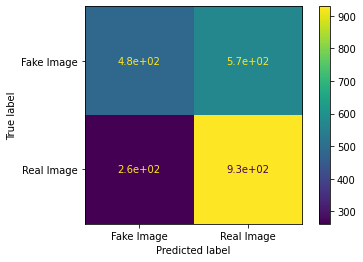

In [ ]:
conf = confusion_matrix(y_test, y_pred_test)
print(conf)
conf = ConfusionMatrixDisplay(conf, ["Fake Image", "Real Image"])
conf.plot()
plt.show()